# Visual Odometry for Localization in Autonomous Driving

- Extract  features from the photographs  taken with a camera setup on the vehicle.
- Use the extracted features to find matches between the features in different photographs.
- Use the found matches to estimate the camera motion between subsequent photographs. 
- Use the estimated camera motion to build the vehicle trajectory.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from m2bk import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)
np.set_printoptions(threshold=2**31-1) # Here we were not able to use np.nan therfore we are using avery small value

## Loading and Visualizing the Data

Below is a convenient dataset handler class to read and iterate through samples taken from the CARLA simulator.

1. The dataset handler contains 52 data frames each frame contains an RGB image and a depth map taken with a setup on the vehicle and a grayscale version of the RGB image which will be used for computation.


2. Camera calibration matrix K is also provided in the dataset handler.


3. Upon creation of the dataset handler object, all the frames will be automatically read and loaded.


4. The frame content can be accessed by using `images`, `images_rgb`, `depth_maps` attributes of the dataset handler object along with the index of the requested frame. 


5. See how to access the images (grayscale), rgb images (3-channel color), depth maps and camera calibration matrix in the example below.

**Note (Depth Maps)**: 

- Maximum depth distance is 1000.


- This value of depth shows that the selected pixel is at least 1000m (1km) far from the camera.


- However the exact distance of this pixel from the camera is unknown. Having this kind of points in further trajectory estimation might affect the trajectory precision.

In [2]:
dataset_handler = DatasetHandler()

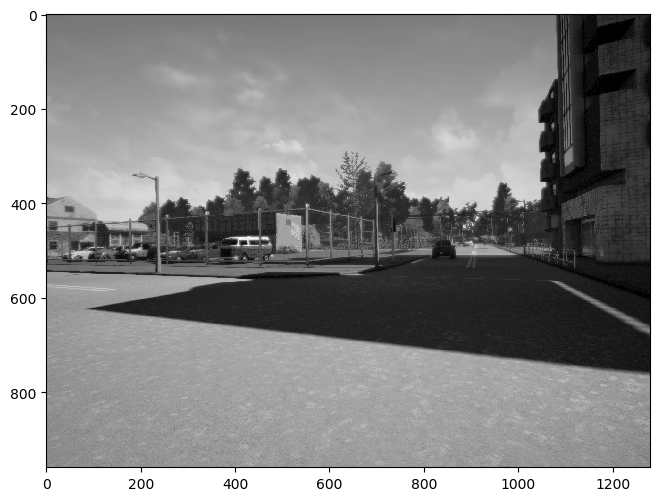

In [3]:
image = dataset_handler.images[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

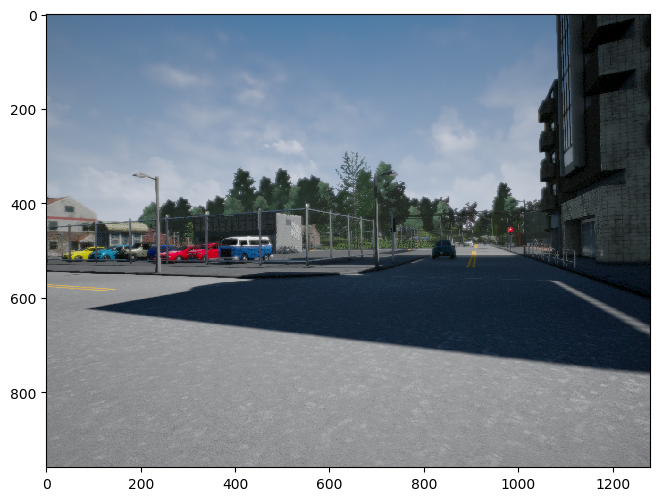

In [4]:
image_rgb = dataset_handler.images_rgb[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

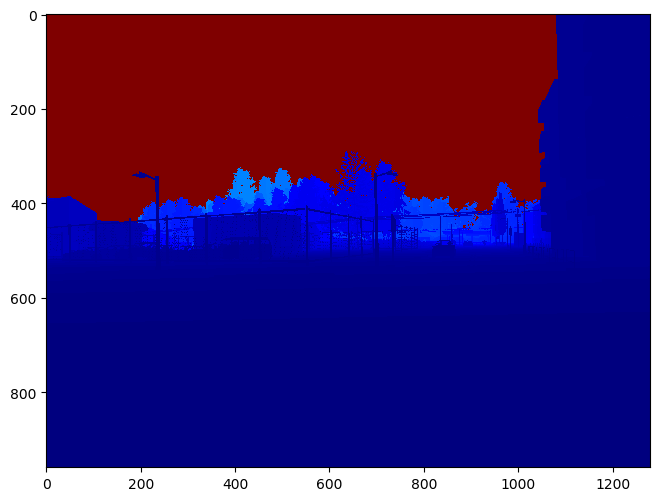

In [5]:
depth = dataset_handler.depth_maps[0]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')

#### Important Values

We in total have 52 frames to access an arbitrary frame use image index. Make sure the indexes are within the number of frames in the dataset. The TOTAL number of frames in the dataset can be accessed with **num_frames attribute.**

In [6]:
print("Depth map shape: {0}".format(depth.shape))
i=0
v, u = depth.shape
depth_val = depth[v-1, u-1]
print("\n Depth value of the very bottom-right pixel of depth map {0} is {1:0.3f}".format(i, depth_val))

# We can access the cameras calibration matrix (K)
print("\n Calibration Matrix (K) = \n\n", dataset_handler.k)

Depth map shape: (960, 1280)

 Depth value of the very bottom-right pixel of depth map 0 is 1.862

 Calibration Matrix (K) = 

 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]


In [7]:
# Number of frames in the dataset
print(dataset_handler.num_frames)

52


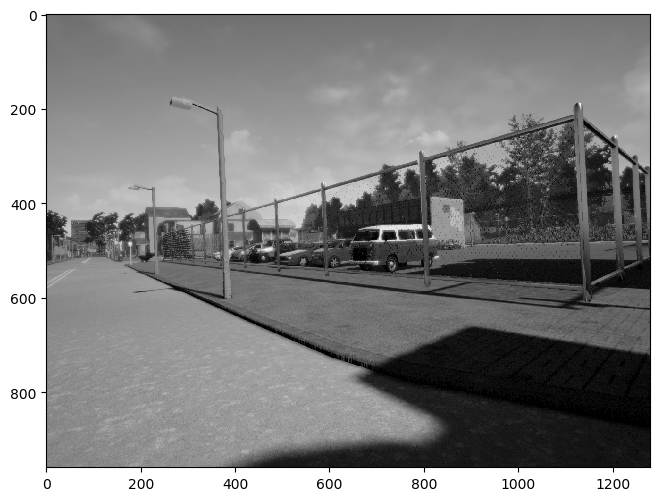

In [8]:
i = 30 # If we want to access the 30th frame of the 52 frames
image = dataset_handler.images[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

## 1. Feature Extraction

### 1.1 - Extracting Features from an Image

We will implement feature extraction from a single image using feature descriptor **ORB (Oriented Fast and Rotated Breif)**. 


1. The structure of the **keypoint descriptor object** [OpenCV: Keypoint Class Description](https://docs.opencv.org/3.4.3/d2/d29/classcv_1_1KeyPoint.html).


2. Keep track of the image coordinate system, namely the origin location and axis directions.


3. A function is provided to visualise the features detected. Run the last 2 cells in section 1.1 to view.


4. Experiment with different **descriptors** such as **SIFT, ORB, SURF and BRIEF**


5. Experiment with different **detectors** such as **Harris corners or FAST and pairing them with a descriptor**.


6. Experiment with changing parameters of the algorithms.
You might find this link useful:  [OpenCV:Feature Detection and Description](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html). 

### ORB in OpenCV

- Create an ORB object with the function, cv.ORB()

    - Parameters:
        - **nFeatures** - Denotes max. no. of features to be retained (default = 500).
        
        - **scoreType** - Denotes whether to use Harris score or FAST score to rank the features (default = Harris score).
                
        - **WTA_K** - Decides no. of points that produce each element of the oriented BRIEF descriptor (default = 2) i.e. selects two points at a time.
        
            - For **matching 2 points**, NORM_HAMMING distance is used.
                
            - If **WTA_K = 3 or 4**, which takes 3 or 4 points to produce BRIEF descriptor, then matching distance is defined by NORM_HAMMING2.

### Find Keypoints and Descriptors for the Image

#### Arguments
   - **image** -  a grayscale image   
   
   - **des2** - list of the keypoint descriptors in the second image

#### Return
   
   - **kp** - list of the extracted keypoints (features) in an image   
   
   - **des** - list of the keypoint descriptors in an image


In [9]:
def extract_features(image):
    
    ### START CODE HERE ### 

    surf = cv.xfeatures2d.SIFT_create()
    kp, des = surf.detectAndCompute(image, None)

    
    ### END CODE HERE ###
    
    return kp, des

In [10]:
i = 0
image = dataset_handler.images[i]
kp, des = extract_features(image)
print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))

print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))

Number of features detected in frame 0: 1507

Coordinates of the first keypoint in frame 0: (4.180473804473877, 457.4769287109375)


### Visualize Extracted Features in the Image

#### Arguments
   - **image** -  a grayscale image
   
   - **kp** - list of the extracted keypoints

In [11]:
def visualize_features(image, kp):
    
    display = cv2.drawKeypoints(image, kp, None)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(display)

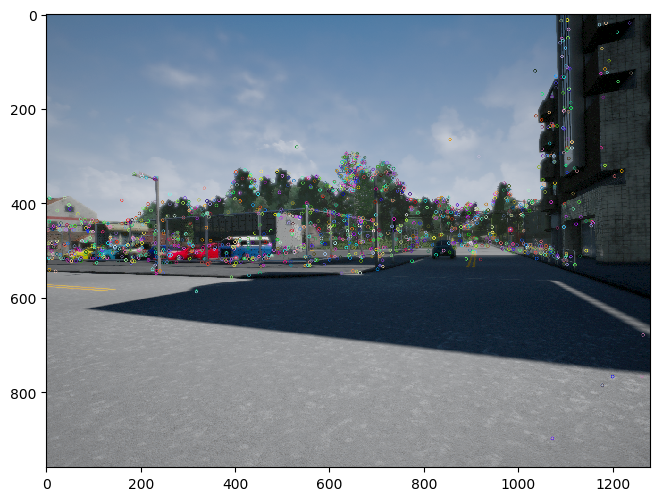

In [12]:
# Optional: visualizing and experimenting with various feature descriptors
i = 0
image = dataset_handler.images_rgb[i]

visualize_features(image, kp)

### 1.2 Extracting Features from Each Image in the Dataset


We will implement feature extraction for each image in the dataset with the function above.

**Note**: To pass functions as arguments.[
Passing Functions as Arguments](https://www.coursera.org/lecture/program-code/passing-functions-as-arguments-hnmqD)

### Find Keypoints and Descriptors for Each Image in the Dataset

#### Arguments
   - **images** -  a list of grayscale images
   
   - **extract_features_function** - a function which finds features (keypoints and descriptors) for an image

#### Return
   
   - **kp_list** - a list of keypoints for each image in images
   
   - **des_list** - a list of descriptors for each image in images


In [13]:
def extract_features_dataset(images, extract_features_function):
    
    kp_list = []
    des_list = []
    
    ### START CODE HERE ###
    for i in images:
        kp, des = extract_features_function(i)
        kp_list.append(kp)
        des_list.append(des)

    ### END CODE HERE ###
    
    return kp_list, des_list

In [14]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 0
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Length of images array: {0}".format(len(images)))

Number of features detected in frame 0: 1507
Coordinates of the first keypoint in frame 0: (4.180473804473877, 457.4769287109375)

Length of images array: 52


## 2. Feature Matching

Next step after extracting the features in each image is matching the features from the subsequent frames.

### 2.1 Matching Features from a Pair of Subsequent Frames

1. Any  feature matching algorithm of choice covered: **Brute Force Matching** or **FLANN** based Matching for example.


2. Implement match filtering by thresholding the distance between the best matches.


3. It can improve overall trajectory estimation results. Recall the option of specifying the number best matches to be returned by the matcher.

### Match features from 2 Images

#### Arguments
   - **des1** -  list of the keypoint descriptors in the first image
   
   
   - **des2** - list of the keypoint descriptors in the second image

#### Return
   
   - **match** - list of matched features from two images. Each match[i] is k or less matches for the same query descriptor


In [15]:
def match_features(des1, des2):
    
    ### START CODE HERE ###
   
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    listof_matched_features_2I = flann.knnMatch(des1, des2, k=2)
        
    ### END CODE HERE ###

    return listof_matched_features_2I

In [16]:
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]

listof_matched_features_2I = match_features(des1, des2)
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(listof_matched_features_2I)))

# Remember that a matcher finds the best matches for EACH descriptor from a query set

Number of features matched in frames 0 and 1: 1507


### Filter Matched features from 2 Images by Distance between the best matches

#### Arguments
   - **match** -  list of matched features from two images
   
   
   - **dist_threshold** - maximum allowed relative distance between the best matches, (0.0, 1.0) 

#### Return
   
   - **filtered_match** - list of good matches, satisfying the distance threshold


In [17]:
# Optional
def filter_matches_distance(listof_matched_features_2I, dist_threshold):
      
    ### START CODE HERE ###
    
    # Because matches are a tuple python can not unpack it, therefore. 
    # for i, j in apple: 
    # This unpacks the tuple's contents into i and j as you're iterating over apple
    
    listof_filtered_features_2I = []
    
    for m,n in listof_matched_features_2I:
        
        if m.distance < dist_threshold*n.distance:
            listof_filtered_features_2I.append([m])
        
    # Which ever distance in m (which is decomposed from the tuple - match)
    # passes through the if statement that distance in m is added to the 
    # filtered_match array which is initialised as a blank array
    
    ### END CODE HERE ###

    return listof_filtered_features_2I

In [18]:
# Feature matching using Threshold distance
dist_threshold = 0.6
listof_filtered_features_2I = filter_matches_distance(listof_matched_features_2I, dist_threshold)

print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(listof_filtered_features_2I)))

Number of features matched in frames 0 and 1 after filtering by distance: 404


### Visualize Corresponding matches in 2 images

#### Arguments
   - **image1** -  the first image in a matched image pair
   
   
   - **kp1** - list of the keypoints in the first image
   
   
   - **image2** -  the seacond image in a matched image pair
   
   
   - **kp2** - list of the keypoints in the second image
   
   
   - **match** - list of matched features from the pair of images

#### Return
   
   - **image_matches** - an image showing the corresponding matches on both image1 and image2 or None if you don't use this function


In [19]:
def visualize_matches(image1, kp1, image2, kp2, match):
    
    image_matches = cv2.drawMatchesKnn(image1, kp1, image2, kp2, match, None, flags=0)
    plt.figure(figsize=(16, 10), dpi=100)
    plt.imshow(image_matches)

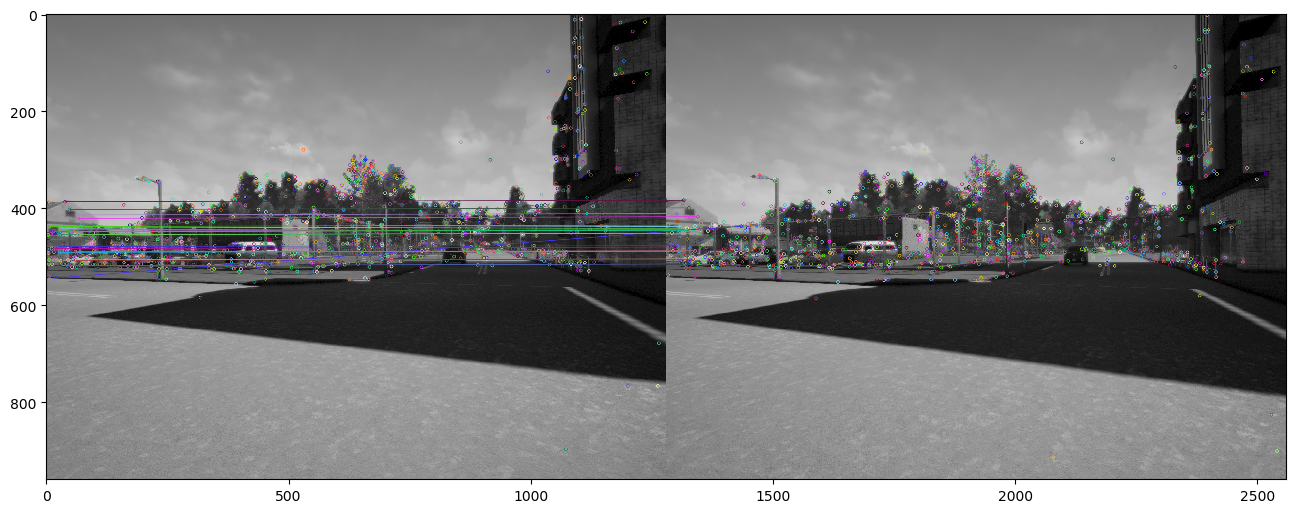

In [20]:
# Visualize n first matches, set n to None to view all matches
# set filtering to True if using match filtering, otherwise set to False
n = 20
filtering = True # The option is to select match_features or filter_matches_distance

i = 0 
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2) # See comment below
if filtering:
    dist_threshold = 0.6
    match = filter_matches_distance(match, dist_threshold) # See comment Below
    
# outImg is a requirement to cv2.drawMatchesKnn you can also write None    
#outImg = np.empty((1,1))

# Reason it is using match[:n] and not any other name is we can choose to use the 
# output of unfiltered and filtered results

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])    

### 2.2 Matching Features in Each Subsequent Image Pair in the Dataset

1. Implement feature matching for each subsequent image pair in the dataset with the function you wrote in the above section.


2. Implement match filtering by thresholding the distance for each subsequent image pair in the dataset with the function you wrote in the above section.

### Match features for each subsequent image pair in the dataset

#### Arguments
   - **des_list** -  a list of descriptors for each image in the dataset
   
   
   - **match_features** - a function which maches features between a pair of images

#### Return
   
   - **matches** - list of matches for each subsequent image pair in the dataset. Each matches[i] is a list of matched features from images i and i + 1


In [21]:
def match_features_dataset(des_list, match_features):
   
    ### START CODE HERE ###
    listof_matches_in_dataset = []
    
    # Match features in the dataset
    
    for i in range(len(des_list)-1):
        des1 = des_list[i]
        des2 = des_list[i+1]
        
        match_in_2_images = match_features(des1, des2)
        
        listof_matches_in_dataset.append(match_in_2_images)   
    
    ### END CODE HERE ###
    
    return listof_matches_in_dataset

In [22]:
listof_matches_in_dataset = match_features_dataset(des_list, match_features)

# ^^^^^ Is also used by filter_matches_dataset to filter by distance

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(listof_matches_in_dataset[i])))

Number of features matched in frames 0 and 1: 1507


### Filter matched features by distance for each subsequent image pair in the dataset

#### Arguments
   - **filter_matches_distance** -  a function which filters matched features from two images by distance between the best matches matches -- list of matches for each subsequent image pair in the dataset. Each matches[i] is a list of matched features from images i and i + 1
   
   
   - **dist_threshold** - maximum allowed relative distance between the best matches, (0.0, 1.0) 

#### Return
   
   - **filtered_matches** - list of good matches for each subsequent image pair in the dataset. Each matches[i] is a list of good matches, satisfying the distance threshold


In [23]:
# Threshold distance matching
def filter_matches_dataset(filter_matches_distance, listof_matches_in_dataset, dist_threshold):
    
    ### START CODE HERE ###
    listof_filtered_matches_dataset = []
    
    # Matching the features by distance in the dataset
    
    for m in listof_matches_in_dataset:
        
        new_match = filter_matches_distance(m,dist_threshold)
        listof_filtered_matches_dataset.append(new_match)

    
    ### END CODE HERE ###
    
    return listof_filtered_matches_dataset

In [24]:
# Threshold distance matching
dist_threshold = 0.6

listof_filtered_matches_dataset = filter_matches_dataset(filter_matches_distance, listof_matches_in_dataset, dist_threshold)

if len(listof_filtered_matches_dataset) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = listof_filtered_matches_dataset

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(listof_filtered_matches_dataset[i])))

Number of filtered matches in frames 0 and 1: 404


# 3. Trajectory Estimation

Incrementally estimate the pose of the vehicle by examining the changes that motion induces on the images of its onboard camera.

### 3.1 Estimating Camera Motion between a Pair of Images

1. Implement camera motion estimation from a pair of images. 


2. Use the motion estimation algorithm Perspective-n-Point (PnP), as well as Essential Matrix Decomposition.


3. For PnP, you will need depth maps of frame and they are provided with the dataset handler. (Check out Section 0)


4. Essential Matrix Decomposition - [Wikipedia: Determining R and t from E](https://en.wikipedia.org/wiki/Essential_matrix).


5. More information on both approaches - [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html).


6. Specifically, _Detailed Description_ section of [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html) as it explains the connection between the 3D world coordinate system and the 2D image coordinate system.



7. Implement camera motion estimation with PnP, PnP with RANSAC and Essential Matrix Decomposition.

### Estimate camera motion from a pair of subsequent image frames

#### Arguments
   - **match** -  list of matched features from the pair of images
   
   
   - **kp1** - list of the keypoints in the first image
   
   
   - **kp2** - list of the keypoints in the second image
   
   
   - **k** - camera calibration matrix
   
#### Optional Arguments
   - **depth1** -  a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition
   
   

#### Return
   
   - **rmat** - recovered 3x3 rotation numpy matrix
   
   
   - **tvec** - recovered 3x1 translation numpy vector
   
   
   - **image1_points** - a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are coordinates of the i-th match in the image coordinate system
   
   
   - **image2_points** - a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are coordinates of the i-th match in the image coordinate system

In [25]:
def estimate_motion(listof_filtered_matches_dataset, kp1, kp2, k, depth1=None):
    
    R_Mat = np.eye(3)
    T_Vector = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
    ### START CODE HERE ###
    # We are constructing an array of 2D points for Image 1 and Image 2
    # These are essentially (x,y) co-ordinates
            
    for m in listof_filtered_matches_dataset:
        m=m[0]
        image1_descriptor = kp1[m.queryIdx].pt
        image2_descriptor = kp2[m.trainIdx].pt
        image1_points.append(image1_descriptor)
        image2_points.append(image2_descriptor)
        
   # for m in listof_filtered_matches_dataset:
   #     m = m[0]
   #     image1_descriptor = m.queryIdx   # Here queryIdx is an attribute of a DMatch Object 
   #     image2_descriptor = m.trainIdx   # listof_filtered_matches_dataset is a list of Dmatch objects
   #             
   #     p1x, p1y = kp1[image1_descriptor].pt
   #     image1_points.append([p1x, p1y])
   #     p2x, p2y = kp2[image2_descriptor].pt
   #     image2_points.append([p2x, p2y])
   #     
   #     points_image1 = np.array(image1_points)
   #     points_image2 = np.array(image2_points)

    Estimated_Ess_Matrix, _ = cv2.findEssentialMat(np.array(image1_points), np.array(image2_points), k, method = cv2.RANSAC)
    
    _, R_Mat, T_Vector, _ = cv2.recoverPose(Estimated_Ess_Matrix, np.array(image1_points), np.array(image2_points), k, 30)
    
    ### END CODE HERE ###
    
    return R_Mat, T_Vector, image1_points, image2_points

In [69]:
i = 50
match = matches[i] # Here matches are listof_filtered_matches_dataset
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("\n Estimated rotation:\n {0}".format(rmat))
print("\n Estimated translation:\n {0}".format(tvec))
x = np.array([[[0], [1], [2]]])
print(x)
print(x.shape)
print(np.squeeze(x).shape)
x1=np.squeeze(x)
print("\n \n",x1)

T = np.array([[[11, 12, 5, 2], [15, 6,10,1], [10, 8, 12, 5], [12,15,8,6]]])
print(T)
print(T.shape)
print(np.squeeze(T).shape)
t1=np.squeeze(T)
print("\n \n",t1)


 Estimated rotation:
 [[ 9.98690931e-01 -1.94097590e-02 -4.73253088e-02]
 [ 1.93649126e-02  9.99811494e-01 -1.40596145e-03]
 [ 4.73436771e-02  4.87670476e-04  9.98878540e-01]]

 Estimated translation:
 [[-0.20465085]
 [-0.02331367]
 [-0.97855736]]
[[[0]
  [1]
  [2]]]
(1, 3, 1)
(3,)

 
 [0 1 2]
[[[11 12  5  2]
  [15  6 10  1]
  [10  8 12  5]
  [12 15  8  6]]]
(1, 4, 4)
(4, 4)

 
 [[11 12  5  2]
 [15  6 10  1]
 [10  8 12  5]
 [12 15  8  6]]


**Expected Output Format**:

Make sure that your estimated rotation matrix and translation vector are in the same format as the given initial values

```
rmat = np.eye(3)
tvec = np.zeros((3, 1))

print("Initial rotation:\n {0}".format(rmat))
print("Initial translation:\n {0}".format(tvec))
```


```
Initial rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Initial translation:
 [[0.]
 [0.]
 [0.]]
```

## Camera Movement Visualization

`visualize_camera_movement` - It visualizes **final image** matches from an image pair connected with an arrow corresponding to direction of camera movement. (when `is_show_img_after_mov = False`). The function description:

**Arguments**
- **image1** - the first image in a matched image pair (RGB or grayscale)


- **image1_points** - a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are coordinates of the i-th match in the image coordinate system


- **image2** - the second image in a matched image pair (RGB or grayscale)


- **image2_points** - a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are coordinates of the i-th match in the image coordinate system



- **is_show_img_after_mov** - a boolean variable, controling the output (read image_move description for more info) 

**Returns**


- **image_move** - an image with the visualization. When `is_show_img_after_mov`**=False** then the **image points from both images are visualized on the first image**. Otherwise, the image points from the second image only are visualized on the second image


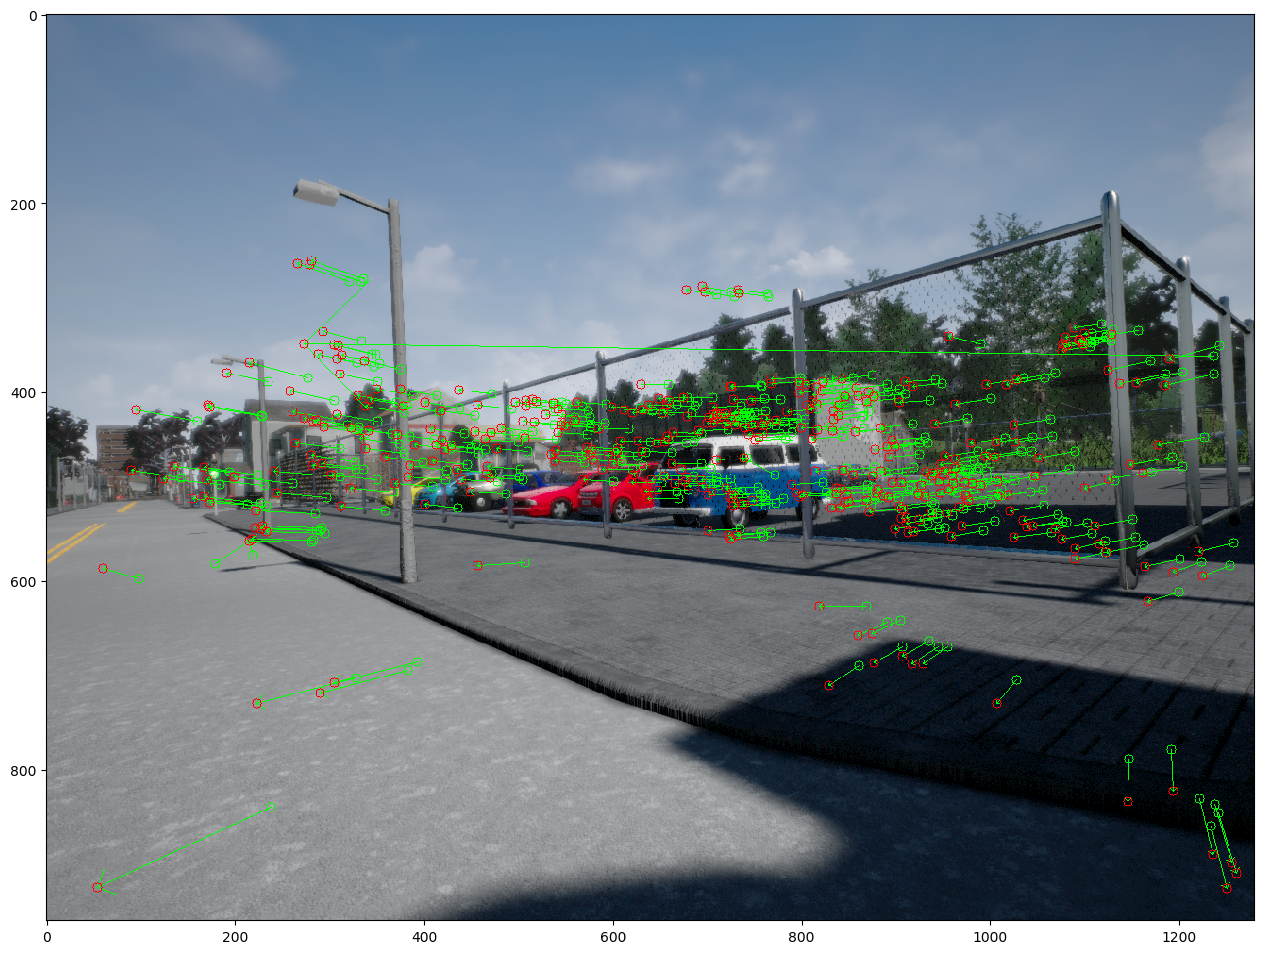

In [27]:
i=30
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

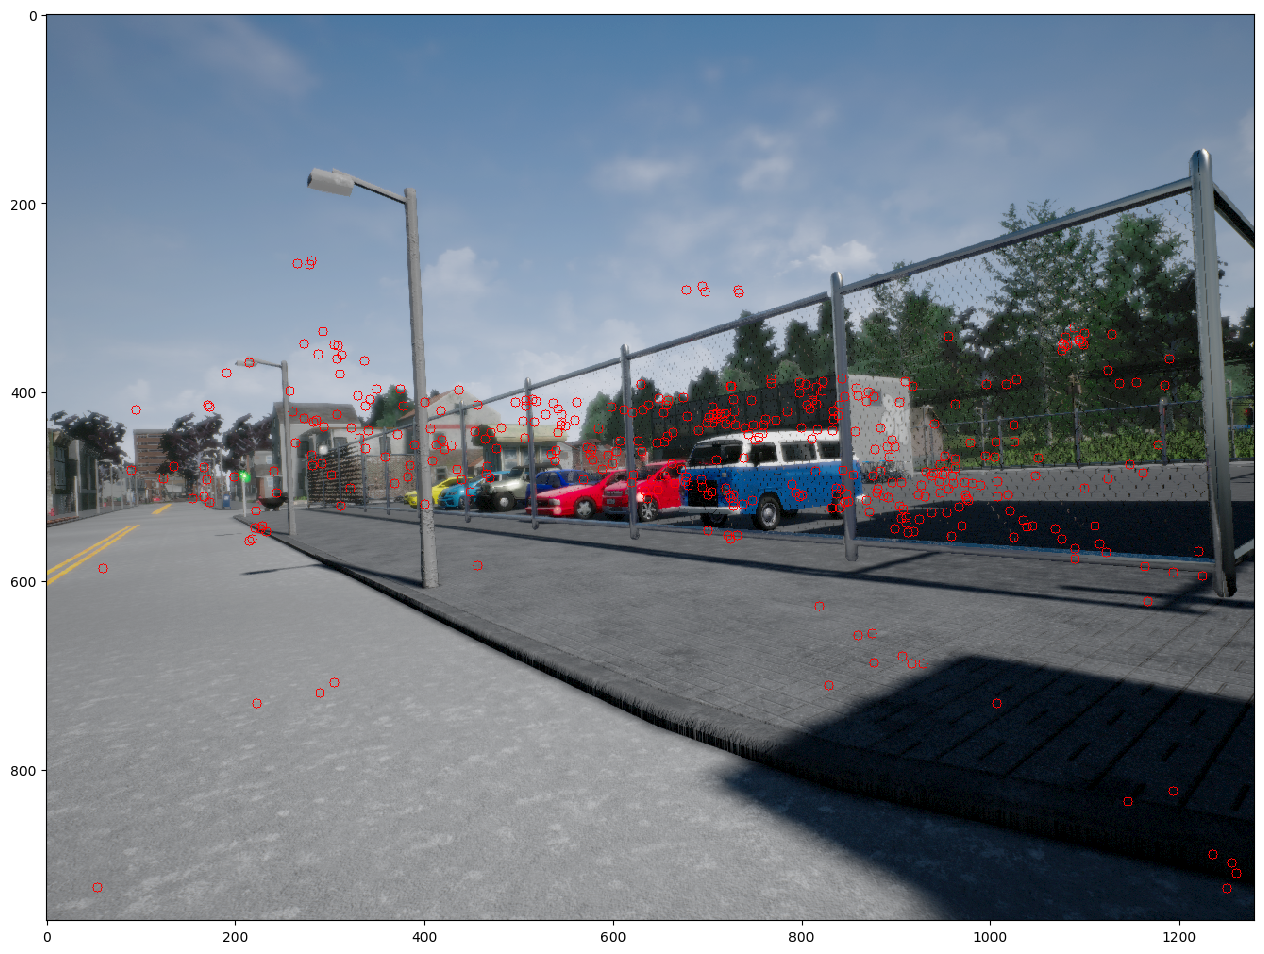

In [28]:
image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, is_show_img_after_move=True)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)
# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation

### 3.2 Camera Trajectory Estimation

Implement camera motion estimation for each subsequent image pair in the dataset with the function you wrote in the above section.

***Note***: Do not forget that the image pairs are not independent one to each other. i-th and (i + 1)-th image pairs have an image in common

### Estimate complete camera trajectory from subsequent image pairs

#### Arguments
   - **estimate_motion** -  a function which estimates camera motion from a pair of subsequent image frames
   
   
   - **matches** - list of matches for each subsequent image pair in the dataset. Each matches[i] is a list of matched features from images i and i + 1
   
   
   - **des_list** - a list of keypoints for each image in the dataset
   
   
   - **k** - camera calibration matrix
   

#### Optional Arguments
   - **depth_maps** -  a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition



#### Return
   
   - **trajectory** - a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and trajectory[:, i] is a 3x1 numpy vector, such as:
   
       - trajectory[:, i][0] - is X coordinate of the i-th location
       - trajectory[:, i][1] - is Y coordinate of the i-th location
       - trajectory[:, i][2] - is Z coordinate of the i-th location
       
       
Consider that the origin of your trajectory cordinate system is located at the camera position when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven at the initialization of this function
 

In [29]:
trajectory = np.zeros((1, 3))
trajectorys = [np.array([0, 0, 0])]
print(trajectory)
print(trajectorys)

[[0. 0. 0.]]
[array([0, 0, 0])]


In [83]:
def estimate_trajectory(estimate_motion, listof_filtered_matches_dataset, kp_list, k, depth_maps=[]):
    
    ### START CODE HERE ###
        
    trajectorys = [np.array([0, 0, 0])]
        
    for i in range(len(listof_filtered_matches_dataset)):
        kp1 = kp_list[i]
        kp2 = kp_list[i+1]
        depth = depth_maps[i]
        
        R, t_old, _, _ = estimate_motion(listof_filtered_matches_dataset[i], kp1, kp2, k, depth1=depth)
        
        transformation_matrix = np.eye(4)
        t_new = t_old.T
        print("\n \n T_OLD - ",t_old)
        print("T_OLD Shape - ",t_old.shape)
        print("\n \n T_New - ",t_new)
        print("T_NEW Shape - ",t_new.shape)
        print(t_new.shape)
        next_transform = np.eye(4)
        next_transform[:3, :3] = R
        next_transform[:3, 3] = t_new
        transformation_matrix = transformation_matrix.dot(np.linalg.inv(next_transform))
        trajectory = transformation_matrix[:3, 3]
        trajectorys.append(trajectory)
        
        
        
        
        
        
        #Camera_motion = np.eye(4)
        #Camera_motion_new = np.eye(4)
        #Camera_motion_new[:3,:4] = np.c_[R_mat.T, -R_mat.T @ T_vector]
        #Camera_motion = Camera_motion @ Camera_motion_new
        
        #trajectory.append(Camera_motion[:3,3])
        
        #np.array(trajectory).T
    
    ### END CODE HERE ###
    
    return np.array(trajectorys).T

In [84]:
depth_maps = dataset_handler.depth_maps

trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)
# Here matches are listof_filtered_matches_dataset
i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))


 
 T_OLD -  [[ 0.08504144]
 [-0.02466883]
 [-0.99607199]]
T_OLD Shape -  (3, 1)

 
 T_New -  [[ 0.08504144 -0.02466883 -0.99607199]]
T_NEW Shape -  (1, 3)
(1, 3)

 
 T_OLD -  [[ 0.00366149]
 [ 0.04382153]
 [-0.99903267]]
T_OLD Shape -  (3, 1)

 
 T_New -  [[ 0.00366149  0.04382153 -0.99903267]]
T_NEW Shape -  (1, 3)
(1, 3)

 
 T_OLD -  [[-9.18864644e-02]
 [ 3.85974416e-04]
 [-9.95769415e-01]]
T_OLD Shape -  (3, 1)

 
 T_New -  [[-9.18864644e-02  3.85974416e-04 -9.95769415e-01]]
T_NEW Shape -  (1, 3)
(1, 3)

 
 T_OLD -  [[ 0.01701798]
 [-0.01586882]
 [-0.99972925]]
T_OLD Shape -  (3, 1)

 
 T_New -  [[ 0.01701798 -0.01586882 -0.99972925]]
T_NEW Shape -  (1, 3)
(1, 3)

 
 T_OLD -  [[-0.04883698]
 [-0.01367962]
 [-0.99871308]]
T_OLD Shape -  (3, 1)

 
 T_New -  [[-0.04883698 -0.01367962 -0.99871308]]
T_NEW Shape -  (1, 3)
(1, 3)

 
 T_OLD -  [[ 0.08998999]
 [ 0.05476402]
 [-0.99443587]]
T_OLD Shape -  (3, 1)

 
 T_New -  [[ 0.08998999  0.05476402 -0.99443587]]
T_NEW Shape -  (1, 3)
(1, 3

**Expected Output**:

```
Camera location in point i is: 
 [[locXi]
 [locYi]
 [locZi]]```
 
 In this output: locXi, locYi, locZi are the coordinates of the corresponding i-th camera location

## 4. Submission:

Evaluation of this assignment is based on the estimated trajectory from the output of the cell below.
Please run the cell bellow, then copy its output to the provided yaml file for submission on the programming assignment page.

**Expected Submission Format**:

```
Trajectory X:
 [[  0.          locX1        locX2        ...   ]]
Trajectory Y:
 [[  0.          locY1        locY2        ...   ]]
Trajectory Z:
 [[  0.          locZ1        locZ2        ...   ]]
```
 
 In this output: locX1, locY1, locZ1; locX2, locY2, locZ2; ... are the coordinates of the corresponding 1st, 2nd and etc. camera locations

In [46]:
# Note: Make sure to uncomment the below line if you modified the original data in any ways
#dataset_handler = DatasetHandler()


# Part 1. Features Extraction
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)


# Part II. Feature Matching
matches = match_features_dataset(des_list, match_features)

# Set to True if you want to use filtered matches or False otherwise
is_main_filtered_m = True
if is_main_filtered_m:
    dist_threshold = 0.75
    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
    matches = filtered_matches

    
# Part III. Trajectory Estimation
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)


#!!! Make sure you don't modify the output in any way
# Print Submission Info
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

Trajectory X:
 [[ 0.         -0.08702489 -0.00403808  0.09237345 -0.01597642  0.04334989
  -0.10348698 -0.11549657 -0.09624294  0.04759813 -0.07695555 -0.14660029
  -0.02168491 -0.14494824 -0.37305802 -0.24079344 -0.24273541 -0.16684836
  -0.00368995 -0.1358044  -0.10099031 -0.11905367 -0.21714456 -0.20653535
  -0.19410998 -0.23734954 -0.05528972 -0.26989902 -0.05388988 -0.11784065
  -0.19695092 -0.22939207 -0.27204835 -0.35986626 -0.36455078 -0.36814525
  -0.37138465 -0.42004089 -0.44868211 -0.45987771 -0.44435507 -0.40321317
  -0.42775931 -0.41563006 -0.26894895 -0.08724188  0.16396116  0.05643749
   0.10897971  0.13748857  0.26018495  0.25116291]]
Trajectory Y:
 [[ 0.          0.02641086 -0.04145967  0.0007998   0.01644917  0.01528368
  -0.05332461  0.04310564  0.03235586  0.00166481 -0.03048406  0.02183908
  -0.01209576 -0.00602454  0.00927696 -0.01615853 -0.00127148 -0.04482236
  -0.06951082  0.05192678  0.02644805 -0.01131176  0.02503521  0.03267496
  -0.01734706  0.03353071 -0.0

### Visualize your Results

**Important**:

1) Make sure your results visualization is appealing before submitting your results. You might want to download this project dataset and check whether the trajectory that you have estimated is consistent to the one that you see from the dataset frames. 

2) Assure that your trajectory axis directions follow the ones in _Detailed Description_ section of [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html).

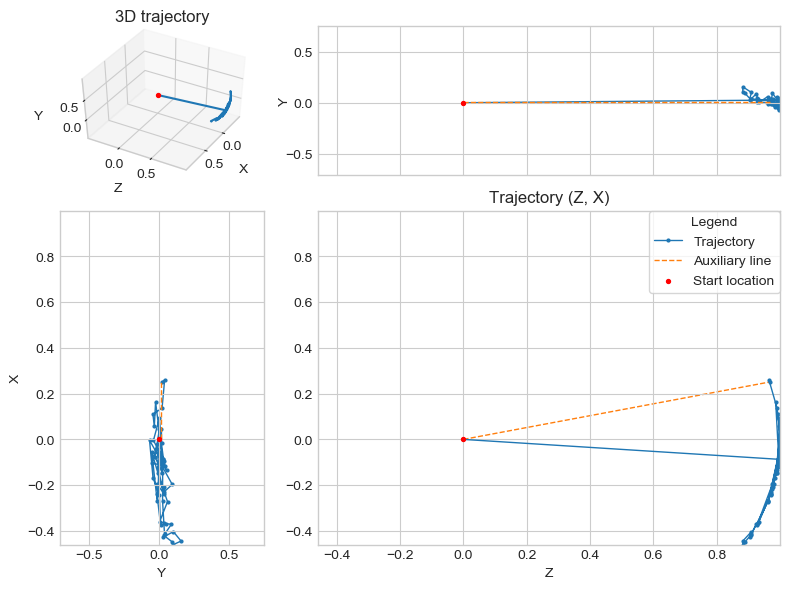

In [47]:
visualize_trajectory(trajectory)

Congrats on finishing this assignment! 